---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 4**: Embeddings & Semantic Search

### 📅 **Due Date**: Day of Lecture 5, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

In this homework, you'll build on Homework 3 (BM25 search) by adding **embedding-based semantic search**.

You will:
1. **Generate embeddings** using both local (Hugging Face) and API (OpenAI) models
2. **Implement cosine similarity** from scratch
3. **Implement semantic search** from scratch
4. **Compare BM25 vs semantic search** using Recall
5. **Compare different embedding models** and analyze their differences

**Total Points: 95**

---

## Instructions

- Complete all tasks by filling in code where you see `# YOUR CODE HERE`
- You may use ChatGPT, Claude, documentation, Stack Overflow, etc.
- When using external resources, briefly cite them in a comment
- Run all cells before submitting to ensure they work

**Submission:**
1. Create a branch called `homework-4`
2. Commit and push your work
3. Create a PR and merge to main
4. Submit the `.ipynb` file on Blackboard

---

## Task 1: Environment Setup (10 points)

### 1a. Imports (5 pts)

Import the required libraries and load the WANDS data.

In [2]:
# ruff: noqa: E402

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# Import ONLY data loading from helpers
import sys
sys.path.append('../scripts')
from helpers import load_wands_products, load_wands_queries, load_wands_labels

# Embedding libraries - we use these directly
from sentence_transformers import SentenceTransformer
import litellm

# Load environment variables for API keys
from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_colwidth', 80)
print("All imports successful!")

All imports successful!


In [3]:
# Load the WANDS dataset
products = load_wands_products(data_dir="data")
queries = load_wands_queries(data_dir="data")
labels = load_wands_labels(data_dir="data")

print(f"Products: {len(products):,}")
print(f"Queries: {len(queries):,}")
print(f"Labels: {len(labels):,}")

Products: 42,994
Queries: 480
Labels: 233,448


### 1b. Copy BM25 functions from HW3 (5 pts)

Copy your BM25 implementation from Homework 3. We'll use it to compare against semantic search.

In [4]:
# Copy your BM25 functions from Homework 3

# Import relevant functions from helpers
from helpers import get_local_model,snowball_tokenize, build_index, score_bm25, search_bm25

products_docs = products['product_name'].astype(str).tolist()
name_index,name_len = build_index(products_docs, snowball_tokenize)
print(f"Index contains {len(name_index):,} unique terms")

Index contains 25,570 unique terms


---

## Task 2: Understanding Embeddings (15 points)

### 2a. Load a local model and generate embeddings (5 pts)

Use `sentence-transformers` to load a local embedding model and generate embeddings for a list of words.

In [5]:
# Load the all-MiniLM-L6-v2 model using SentenceTransformer
# Then generate embeddings for each word in the list
words = ["wooden coffee table", "oak dining table", "red leather sofa", "blue area rug", "kitchen sink"]

# YOUR CODE HERE
#using helper function get_local_model that returns SentenceTransformer model instance
model = get_local_model("all-MiniLM-L6-v2") 
word_embed = model.encode(words)

# Print the number of embeddings you generated and the dimension of the embeddings
print(f"Generated embeddings: {len(word_embed)}")
print(f"Embedding dimension: {(word_embed.shape[1])}")

Loading model 'all-MiniLM-L6-v2' from Hugging Face...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 202.71it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded! Embedding dimension: 384
Generated embeddings: 5
Embedding dimension: 384


### 2b. Implement cosine similarity and create a similarity matrix (5 pts)

Implement cosine similarity from scratch:

$$\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \times \|b\|}$$

In [6]:
# Implement cosine similarity from scratch
# From lecture
def cosine_similarity_manual(a, b):
    """Calculate cosine similarity between two vectors."""
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# # Create similarity matrix
n = len(words)
similarity_matrix = np.zeros((n,n)) #initialize empty matrix

for w1 in range(n):
    for w2 in range(n):
        similarity_matrix[w1, w2] = cosine_similarity_manual(word_embed[w1], word_embed[w2])
# # Display as DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
display(similarity_df.style.background_gradient(cmap='Blues'))

,wooden coffee table,oak dining table,red leather sofa,blue area rug,kitchen sink
wooden coffee table,1.000000,0.588631,0.370622,0.189486,0.295712
oak dining table,0.588631,1.000000,0.337910,0.249521,0.341410
red leather sofa,0.370622,0.337910,1.000000,0.380310,0.057740
blue area rug,0.189486,0.249521,0.380310,1.000000,0.125802
kitchen sink,0.295712,0.341410,0.057740,0.125802,1.000000


### 2c. Embed using OpenAI API (5 pts)

Use `litellm` to get embeddings from OpenAI's API and compare dimensions.

In [7]:
#Generated in Gemini to understand concept
response = litellm.embedding(
    model="text-embedding-3-large", 
    input=words
)
# 2. Convert the entire response to a single NumPy matrix
# response.data is a list of objects; we extract the 'embedding' from each 
embeddings_array = np.array([r["embedding"] for r in response.data])

# 3. Create a dictionary mapping for easy lookup (if you still need it)
embeddings_dict = dict(zip(words, embeddings_array))

# Verify the shape
print(f"Matrix shape: {embeddings_array.shape}") # (len(words), 3072)

Matrix shape: (5, 3072)


In [8]:
# Use litellm to get an embedding from OpenAI's text-embedding-3-small model
# Compare the dimension with the local model
embeddings = {}
for word in words:
    response = litellm.embedding(model="text-embedding-3-large", input=[word])
    embeddings[word] = np.array(response.data[0]["embedding"])

print("Similarity matrix:")

word_width = max(len(w) for w in words) + 2
header = "".join([f"{'':<{word_width}s}"] + [f"{w:>{word_width}s}" for w in words])
print(header)
print("-" * (word_width + len(words) * word_width))

for w1 in words:
    row = [f"{w1:<{word_width}s}"]
    for w2 in words:
        # Cosine similarity: dot product divided by product of norms
        sim = np.dot(embeddings[w1], embeddings[w2]) / (np.linalg.norm(embeddings[w1]) * np.linalg.norm(embeddings[w2]))
        row.append(f"{sim:>{word_width}.2f}")
    print("".join(row))

print("\nComparing dimension with local model:")

openai_dim = len(next(iter(embeddings.values())))
local_dim = word_embed.shape[1]

print(f"OpenAI (API): {openai_dim} dimensions")
print(f"MiniLM (Local): {local_dim} dimensions")
print(f"OpenAI dimensions are 8x larger than the local model dimensions (3072/384)")

Similarity matrix:
                       wooden coffee table     oak dining table     red leather sofa        blue area rug         kitchen sink
------------------------------------------------------------------------------------------------------------------------------
wooden coffee table                   1.00                 0.54                 0.35                 0.28                 0.22
oak dining table                      0.54                 1.00                 0.35                 0.27                 0.29
red leather sofa                      0.35                 0.35                 1.00                 0.37                 0.27
blue area rug                         0.28                 0.27                 0.37                 1.00                 0.19
kitchen sink                          0.22                 0.29                 0.27                 0.19                 1.00

Comparing dimension with local model:
OpenAI (API): 3072 dimensions
MiniLM (Local): 384 dim

---

## Task 3: Batch Embedding Products (20 points)

### 3a. Embed a product sample (10 pts)

Create a combined text field and embed 5,000 products using the local model.

In [9]:
# Get a consistent sample
products_sample = products.sample(n=5000, random_state=42).reset_index(drop=True)
print(f"Working with {len(products_sample):,} products")
products_sample[['product_id', 'product_name', 'product_class']].head()

Working with 5,000 products


,product_id,product_name,product_class
0,32193,woven wire basket,"Boxes, Bins, Baskets, & Buckets"
1,21379,scallop nightstand,Kids Nightstands
2,42275,ybm home stainless steel colander,"Strainers, Colanders, & Salad Spinners"
3,29885,oneida 2 piece stainless steel strainer set,"Strainers, Colanders, & Salad Spinners"
4,8194,ryland platform bed frame,Bed Frames|Beds


In [10]:
from helpers import batch_embed_local

In [11]:
# Create a combined text field (product_name + product_class)
# Then embed all products using model.encode()

# YOUR CODE HERE
# Creates a combined text field (product_name + product_class)
products_sample['embed_text'] = (
    products_sample['product_name'].fillna('') + ' ' +
    products_sample['product_class'].fillna('')
)

products_sample['embed_text'].head()

# Then embeds all products using model.encode()
print("Embedding products...")
start = time.time()
product_embeddings = batch_embed_local(
    products_sample['embed_text'].tolist(),
    show_progress=True
)
print(f"Done in {time.time() - start:.1f}s")
print(f"Embeddings shape: {product_embeddings.shape}")

Embedding products...


Batches: 100%|██████████| 157/157 [00:44<00:00,  3.49it/s]

Done in 45.1s
Embeddings shape: (5000, 384)


### 3b. Save and load embeddings (5 pts)

Save embeddings to a `.npy` file so you don't have to recompute them.

In [12]:
# Save embeddings to ../temp/hw4_embeddings.npy
# Save products_sample to ../temp/hw4_products.csv
# Then load them back and verify they match

#Saves embeddings and product sample
np.save('temp/hw4_embeddings.npy', product_embeddings)
products_sample.to_csv('temp/hw4_products.csv', index=False)
print("Saved embeddings and sample to '/temp/'")

#Loads them back and verify they match
print(f"Loading embeddings...")
load_embeddings = np.load('temp/hw4_embeddings.npy')
load_products = pd.read_csv('temp/hw4_products.csv')

embeddings_match = np.array_equal(product_embeddings, load_embeddings) #collaborated with Gemini
products_match = products_sample.equals(load_products)

print(f"Embeddings verified: {embeddings_match}")
print(f"Products CSV verified: {products_match}")

print("\nDouble-check shapes match between loaded and embedded")
print(f"Product Embedding Shape: {product_embeddings.shape}")
print(f"Product Sample Shape: {products_sample.shape}")
print(f"Loaded Embeddings Shape: {load_embeddings.shape}")
print(f"Loaded Products Shape: {load_products.shape}")

Saved embeddings and sample to '/temp/'
Loading embeddings...
Embeddings verified: True
Products CSV verified: True

Double-check shapes match between loaded and embedded
Product Embedding Shape: (5000, 384)
Product Sample Shape: (5000, 10)
Loaded Embeddings Shape: (5000, 384)
Loaded Products Shape: (5000, 10)


### 3c. Cost estimation (5 pts)

Estimate the cost to embed all 43K products using OpenAI's API.

**Pricing**: text-embedding-3-small costs ~$0.02 per 1 million tokens.

In [13]:
# Use tiktoken to count actual tokens in the sample
# Then extrapolate to estimate cost for the full dataset
#Reference: Gemini
import tiktoken

# Initialize the tokenizer for OpenAI's v3 models
encoding = tiktoken.get_encoding("cl100k_base")

# Count tokens in sample words
token_counts = [len(encoding.encode(word)) for word in products_sample['embed_text']]
avg_tokens_per_product = np.mean(token_counts)
total_tokens = sum(token_counts)

# Extrapolate to the full dataset
total_products = 43000
estimated_total_tokens = avg_tokens_per_product * total_products

# Calculate Cost
# Pricing: $0.02 per 1,000,000 tokens
cost_per_1m = 0.02
estimated_cost = (estimated_total_tokens / 1_000_000) * cost_per_1m

print(f"Actual tokens in sample: {total_tokens:,.0f}")
print(f"Average tokens per product: {avg_tokens_per_product:.2f}")
print(f"Estimated total tokens for 43K products: {estimated_total_tokens:,.0f}")
print(f"Estimated Total Cost: ${estimated_cost:.4f}")

Actual tokens in sample: 65,077
Average tokens per product: 13.02
Estimated total tokens for 43K products: 559,662
Estimated Total Cost: $0.0112


---

## Task 4: Semantic Search (25 points)

### 4a. Implement semantic search (15 pts)

Implement a semantic search function from scratch.

In [14]:
# Implement batch cosine similarity for efficiency
def batch_cosine_similarity(query_emb: np.ndarray, doc_embs: np.ndarray) -> np.ndarray:
    """
    Calculate cosine similarity between query and all documents.

    Args:
        query_emb: Query embedding vector
        doc_embs: Document embeddings matrix (num_docs, embedding_dim)

    Returns:
        Array of similarity scores for each document
    """
    query_norm = query_emb / np.linalg.norm(query_emb)
    doc_norms = doc_embs / np.linalg.norm(doc_embs, axis=1, keepdims=True)
    return doc_norms @ query_norm

In [15]:
# Implement semantic search
def semantic_search_local(query, product_embeddings, products_df, k=10):
    """Search products using local embedding similarity."""
    # 1. Embed the query
    model = get_local_model("all-MiniLM-L6-v2")
    query_emb = model.encode(query, convert_to_numpy=True)
    
    # 2. Calculate similarity to all products
    similarities = batch_cosine_similarity(query_emb, product_embeddings)
    
    # 3. Get top-k indices
    top_k_idx = np.argsort(-similarities)[:k]
    
    # 4. Build results DataFrame
    results = products_df.iloc[top_k_idx].copy()
    results['similarity'] = similarities[top_k_idx]
    results['rank'] = range(1, k + 1)
    
    return results

In [16]:
# Test semantic search
results = semantic_search_local("basket", product_embeddings, products_sample)
results[['rank', 'product_name', 'product_class', 'similarity']]

,rank,product_name,product_class,similarity
4943,1,laundry basket,NaN,0.708730
811,2,edition 11 laundry basket,Hampers & Baskets,0.538334
3629,3,square wire basket,"Boxes, Bins, Baskets, & Buckets",0.520790
4691,4,lucinda metal/wire basket,"Boxes, Bins, Baskets, & Buckets",0.494276
0,5,woven wire basket,"Boxes, Bins, Baskets, & Buckets",0.487159
90,6,tier commerical basket utility cart,Carts & Stands,0.460876
4029,7,planter solid wood basket,"Boxes, Bins, Baskets, & Buckets",0.456729
2979,8,scoop stacking metal/wire basket,"Boxes, Bins, Baskets, & Buckets",0.451220
1560,9,metal stand with 9 wire basket,"Boxes, Bins, Baskets, & Buckets",0.448723
3107,10,shaker style hamper,Hampers & Baskets,0.438528


### 4b. Evaluate and compare BM25 vs semantic search (10 pts)

Implement Recall@k and compare the two search methods.

In [17]:
# Implement Recall@k - from class notes
def evaluate_search(
    search_func,
    queries_df: pd.DataFrame,
    labels_df: pd.DataFrame,
    k: int = 10,
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Evaluate search across all queries using Recall@k.

    Recall@k = (# relevant items found in top k) / (total # relevant items)

    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress

    Returns:
        DataFrame with query_id, query, and recall columns
    """
    results = []

    for _, row in queries_df.iterrows():
        query_id = row["query_id"]
        query_text = row["query"]

        search_results = search_func(query_text)
        product_ids = search_results["product_id"].tolist()[:k]

        # Recall calculation (grade > 0 = relevant)
        query_labels = labels_df[labels_df["query_id"] == query_id]
        relevant_ids = set(query_labels[query_labels["grade"] > 0]["product_id"])
        retrieved_ids = set(product_ids)
        recall = (
            len(retrieved_ids & relevant_ids) / len(relevant_ids)
            if relevant_ids
            else 0.0
        )

        results.append(
            {
                "query_id": query_id,
                "query": query_text,
                "recall": recall,
            }
        )

    results_df = pd.DataFrame(results)

    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean Recall@{k}: {results_df['recall'].mean():.4f}")

    return results_df

In [18]:
# Build BM25 index for comparison
sample_index, sample_lengths = build_index(products_sample['product_name'].tolist())
# Filter queries to those with products in our sample
sample_product_ids = set(products_sample['product_id'])
sample_labels = labels[labels['product_id'].isin(sample_product_ids)]
sample_query_ids = set(sample_labels['query_id'])
sample_queries = queries[queries['query_id'].isin(sample_query_ids)]

print(f"Queries with products in sample: {len(sample_queries)}")

Queries with products in sample: 473


In [23]:
# Evaluate both BM25 and semantic search on all queries
# Calculate Recall@10 for each method
print("Evaluating BM25...")
bm25_eval = evaluate_search(
    lambda q: search_bm25(q, sample_index, products_sample, sample_lengths, k=10),
    sample_queries, sample_labels, k=10
)

print("\nEvaluating Semantic Search...")
semantic_eval = evaluate_search(
    lambda q: semantic_search_local(q, product_embeddings, products_sample, k=10),
    sample_queries, sample_labels, k=10
)

Evaluating BM25...
Evaluated 473 queries
Mean Recall@10: 0.3559

Evaluating Semantic Search...
Evaluated 473 queries
Mean Recall@10: 0.3253


In [24]:
comparison = bm25_eval.merge(semantic_eval, on=['query_id', 'query'], suffixes=('_bm25', '_semantic'))
comparison['diff'] = comparison['recall_semantic'] - comparison['recall_bm25']

print("\n" + "="*40)
print("COMPARISON")
print("="*40)
print(f"BM25 Mean Recall@10:     {bm25_eval['recall'].mean():.4f}")
print(f"Semantic Mean Recall@10: {semantic_eval['recall'].mean():.4f}")
print(f"Semantic wins: {(comparison['diff'] > 0).sum()} queries")
print(f"BM25 wins: {(comparison['diff'] < 0).sum()} queries")
print(f"Tie: {(comparison['diff'] == 0).sum()} queries")


COMPARISON
BM25 Mean Recall@10:     0.3559
Semantic Mean Recall@10: 0.3253
Semantic wins: 123 queries
BM25 wins: 168 queries
Tie: 182 queries


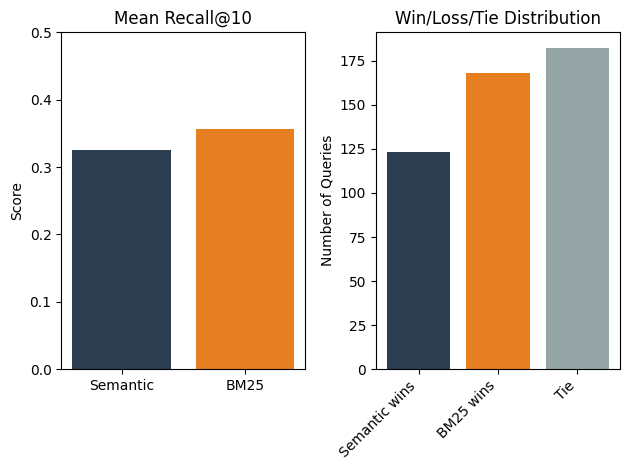

In [32]:
# Visualize comparison
# Collaboration with Gemini
# Prepare the data
mean_recall_df = pd.DataFrame({
    'Method': ['BM25', 'Semantic'],
    'Score': [bm25_eval['recall'].mean(), semantic_eval['recall'].mean()]
}).sort_values('Score', ascending=True)

# Wins by search
semantic_wins = (comparison['diff'] > 0).sum()
bm25_wins = (comparison['diff'] < 0).sum()
tied = (comparison['diff'] == 0).sum()
win_dist_df = pd.DataFrame({
    'Category': ['Tie', 'BM25 wins', 'Semantic wins'],
    'Count': [tied, bm25_wins, semantic_wins]
}).sort_values('Count', ascending=True)

plt.subplot(1,2,1)
plt.bar(mean_recall_df['Method'], mean_recall_df['Score'], color=['#2c3e50', '#e67e22'])
plt.title('Mean Recall@10')
plt.ylabel('Score')
plt.ylim(0, 0.5)

plt.subplot(1, 2, 2)
plt.bar(win_dist_df['Category'], win_dist_df['Count'], color=['#2c3e50','#e67e22','#95a5a6'])
plt.xticks(rotation=45, ha='right')
plt.title('Win/Loss/Tie Distribution')
plt.ylabel('Number of Queries')

plt.tight_layout()
plt.savefig('search_comparison.png')

---

## Task 5: Compare Embedding Models (20 points)

### 5a. Embed products with two different models (10 pts)

Compare embeddings from:
- `BAAI/bge-base-en-v1.5`
- `sentence-transformers/all-mpnet-base-v2`

In [37]:
# Load the two embedding models
bge_model = get_local_model("BAAI/bge-base-en-v1.5") 
mpnet_model = get_local_model("sentence-transformers/all-mpnet-base-v2") 

In [39]:
# Embed products with both models
# Gemini: normalize_embeddings added to 
products = products_sample['product_name'].tolist()
bge_embed = bge_model.encode(products, show_progress_bar=True)
mpnet_embed = mpnet_model.encode(products, show_progress_bar=True)
# Print the number of embeddings you generated and the dimension of the embeddings
print(f"Generated embeddings: {len(bge_embed)}")
print(f"Embedding dimension: {(bge_embed.shape[1])}")
print(f"Generated embeddings: {len(mpnet_embed)}")
print(f"Embedding dimension: {(mpnet_embed.shape[1])}")

Batches: 100%|██████████| 157/157 [14:06<00:00,  5.39s/it]


Generated embeddings: 5000
Embedding dimension: 768
Generated embeddings: 5000
Embedding dimension: 768


### 5b. Compare search results between models (10 pts)

Evaluate both models on the same queries and analyze differences.

In [42]:
# Implement semantic search takes any model
def semantic_search_all(query, product_embeddings, products_df, model_name, k=10):
    """Search products using local embedding similarity."""
    # 1. Embed the query
    model = get_local_model(model_name)
    query_emb = model.encode(query, convert_to_numpy=True, normalize_embeddings=True)
    
    # 2. Calculate similarity to all products
    # Since query and product_embeddings are pre-normalized, @ is Cosine Similarity
    similarities = product_embeddings @ query_emb
    
    # 3. Get top-k indices
    top_k_idx = np.argsort(-similarities)[:k]
    
    # 4. Build results DataFrame
    results = products_df.iloc[top_k_idx].copy()
    results['similarity'] = similarities[top_k_idx]
    results['rank'] = range(1, k + 1)
    
    return results

In [43]:
# Compare results for specific queries
test_queries = ["comfortable sofa", "star wars rug", "modern coffee table","vacuum cleaner", "air fryer", "cheese grater"]
# add more!

In [47]:
for q in test_queries:
    print(f"Query: {q}")
    print(f"Evaluating BGE...")
    display(
        semantic_search_all(q, bge_embed, products_sample, "BAAI/bge-base-en-v1.5")
        [["rank","product_name", "product_class", "similarity"]]
    )
    print(f"Evaluating MPNET...")
    display(
        semantic_search_all(q, mpnet_embed, products_sample, "all-mpnet-base-v2")
        [["rank","product_name", "product_class", "similarity"]]
    )

Query: comfortable sofa
Evaluating BGE...


,rank,product_name,product_class,similarity
3296,1,chaise lounge floor sofa,Game Chairs,0.836463
2631,2,yland patio sofa with cushions,Patio Sofas,0.828282
4523,3,kaing patio sofa with cushions,Patio Sofas,0.814701
4722,4,honeycutt patio sofa with cushions,Patio Sofas,0.814534
1501,5,alliser 87 '' square arm reclining sofa,Sofas,0.812898
611,6,arshleen patio sofa with cushions,Patio Sofas,0.810895
3341,7,brunswick teak patio sofa with cushions,Patio Sofas,0.810527
2105,8,desberg patio sofa with cushions,Patio Sofas,0.808911
4423,9,claremore 95 '' square arm sofa with reversible cushions,Sofas,0.808874
2736,10,baeten patio sofa with cushions,NaN,0.808783


Evaluating MPNET...
Loading model 'all-mpnet-base-v2' from Hugging Face...


Loading weights: 100%|██████████| 199/199 [00:02<00:00, 86.64it/s, Materializing param=pooler.dense.weight]                         
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded! Embedding dimension: 768


,rank,product_name,product_class,similarity
611,1,arshleen patio sofa with cushions,Patio Sofas,0.744249
147,2,phokas 93 '' square arm sofa,NaN,0.726604
3341,3,brunswick teak patio sofa with cushions,Patio Sofas,0.724071
4722,4,honeycutt patio sofa with cushions,Patio Sofas,0.723300
2410,5,noor 74 '' wide patio sofa with cushions,Patio Sofas,0.717676
2631,6,yland patio sofa with cushions,Patio Sofas,0.717500
4768,7,castilloux patio sofa with cushions,Patio Sofas,0.714821
2993,8,lenville patio sofa,Patio Sofas,0.710815
3371,9,samuel 91 '' velvet flared arm sofa,Sofas,0.710591
964,10,aidann patio sectional with cushions,Patio Sofas,0.709639


Query: star wars rug
Evaluating BGE...


,rank,product_name,product_class,similarity
3270,1,multi area rug,Licensed Products|Area Rugs,0.802959
951,2,sylvain oriental raspberry area rug,Area Rugs,0.802261
4063,3,dinosaur land area rug,Area Rugs,0.802160
3878,4,wellspring multi area rug,Area Rugs,0.801346
654,5,rihanna ikat plum area rug,Area Rugs,0.800771
1850,6,matilda power loom red/beige rug,Area Rugs,0.799886
3835,7,tufted red/brown area rug,Area Rugs,0.797249
3013,8,jakat gray rug,Area Rugs,0.797080
4555,9,power loom red/brown rug,Area Rugs,0.795431
4081,10,vahakn wool multi-colored area rug,Area Rugs,0.794213


Evaluating MPNET...


,rank,product_name,product_class,similarity
299,1,surbur gray rug,Area Rugs,0.658833
3013,2,jakat gray rug,Area Rugs,0.654332
1545,3,gray rug,Area Rugs,0.653089
1363,4,sulien gray rug,Area Rugs,0.643988
4368,5,runner brandt oriental hand-knotted wool beige area rug,Area Rugs,0.637740
1017,6,rugsotic carpets hand-knotted silk blue area rug,Area Rugs,0.633150
3632,7,rutz all the way memory foam bath rug,Bath Rugs & Mats,0.631203
2403,8,melynda gray rug,Area Rugs,0.630341
4952,9,animal print hand knotted wool black/beige area rug,Area Rugs,0.630061
3982,10,tribal southwestern cream area rug,Area Rugs,0.629436


Query: modern coffee table
Evaluating BGE...


,rank,product_name,product_class,similarity
3754,1,coffee table,Coffee & Cocktail Tables,0.887310
695,2,updegraff contemporary rect coffee table,Coffee & Cocktail Tables,0.874049
3839,3,choual coffee table,Coffee & Cocktail Tables,0.863529
2860,4,coffee table with storage,NaN,0.850943
528,5,coffee table with storage,Coffee & Cocktail Tables,0.850943
214,6,wooden coffee table,Coffee & Cocktail Tables,0.849639
586,7,florie solid coffee table,NaN,0.845395
122,8,bohemian coffee table,Coffee & Cocktail Tables,0.839886
352,9,4 legs coffee table,Coffee & Cocktail Tables,0.835794
1175,10,kober frame coffee table,Coffee & Cocktail Tables,0.830457


Evaluating MPNET...


,rank,product_name,product_class,similarity
3754,1,coffee table,Coffee & Cocktail Tables,0.869143
3839,2,choual coffee table,Coffee & Cocktail Tables,0.849712
214,3,wooden coffee table,Coffee & Cocktail Tables,0.815659
1858,4,ahern coffee table,Coffee & Cocktail Tables,0.808063
942,5,kernville coffee table,Coffee & Cocktail Tables,0.796548
303,6,pafford coffee table,NaN,0.795622
2883,7,revere coffee table,Coffee & Cocktail Tables,0.790898
122,8,bohemian coffee table,Coffee & Cocktail Tables,0.790173
4379,9,possenriede coffee table,Coffee & Cocktail Tables,0.788269
355,10,mcquade coffee table,Coffee & Cocktail Tables,0.784509


Query: vacuum cleaner
Evaluating BGE...


,rank,product_name,product_class,similarity
8,1,multi-functional manual noodle machine dumpling skin maker kitchen equipment .,Pasta Makers & Accessories,0.632020
3270,2,multi area rug,Licensed Products|Area Rugs,0.626715
2764,3,musa wall mounted towel ring,Towel Rings,0.617359
2115,4,rolling laundry cart,Laundry Accessories & Storage,0.613692
4757,5,shag gray/white rug,Area Rugs,0.612098
1275,6,lavatory lift rod and finial,Fixture Parts And Components,0.611777
3852,7,stiltner waste basket,Trash Cans & Recycling,0.609735
2854,8,farberware professional 1.0 cu . ft. top load washer,Washing Machines,0.608514
2539,9,pineapple 1 qt . kitchen canister,NaN,0.608132
3853,10,drage 7 drawer dresser,Dressers & Chests,0.605370


Evaluating MPNET...


,rank,product_name,product_class,similarity
4943,1,laundry basket,NaN,0.458662
1545,2,gray rug,Area Rugs,0.425731
3941,3,shop light,Commercial Ceiling Lighting,0.411635
1461,4,bathroom soap dish,Bath Accessories,0.408712
3885,5,old master pasta scoop,Flatware & Silverware Serving Pieces,0.407917
3281,6,carbon monoxide detector,Smoke & CO Detectors,0.385626
1102,7,aliandra fashion casual lift chair office work beauty salon task chair,NaN,0.379755
299,8,surbur gray rug,Area Rugs,0.378702
1363,9,sulien gray rug,Area Rugs,0.377988
2093,10,diva toothbrush holder,Bath Accessories,0.376031


Query: air fryer
Evaluating BGE...


,rank,product_name,product_class,similarity
4977,1,cuisinart 6 quart 3-in-1 cook central® multicooker,Slow Cookers,0.670238
2294,2,"ayesha home collection stainless steel frying pan , 8.5-inch",Skillets & Fry Pans,0.661348
530,3,hamilton beach 1.5 qt . compact multi cooker,Slow Cookers,0.652261
1441,4,"aroma 5 qt . cool touch digital slow cooker , food steamer and rice cooker",Slow Cookers,0.651642
3300,5,all-clad 7 qt . slow cooker,Slow Cookers,0.645481
273,6,800 series 30 '' gas cooktop with 5 burners,Cooktops,0.641664
4099,7,courant 5 qt . slow cooker,Slow Cookers,0.639554
4089,8,samsung 7.5 cu . ft. gas stackable dryer with sensor dry in black,Dryers,0.639025
3143,9,ge appliances smart 5 cu . ft. top load washer and 7.4 cu . ft. gas dryer,Washer and Dryer Sets,0.635713
2457,10,crock-pot 7 qt . slow cooker,Slow Cookers,0.634396


Evaluating MPNET...


,rank,product_name,product_class,similarity
3105,1,metal cachepot,Planters,0.439487
3690,2,ovente electric hot plate,Burners & Hot Plates,0.436300
4654,3,fish platter,Serving Dishes & Platters,0.404911
2294,4,"ayesha home collection stainless steel frying pan , 8.5-inch",Skillets & Fry Pans,0.404704
2052,5,zing oval slow cooker,Slow Cookers,0.398649
1575,6,kettlepizza gas pro – basic,Grill Parts,0.396612
4653,7,supreme pizza slice float inflatable,Outdoor Decorations,0.388565
762,8,29.375 '' 600 cfm convertible under cabinet range hood stainless steel,Range Hoods,0.385035
262,9,green4ever 4.5 qt . slow cooker,Slow Cookers,0.383709
4688,10,ovente induction hot plate,Burners & Hot Plates,0.380267


Query: cheese grater
Evaluating BGE...


,rank,product_name,product_class,similarity
3885,1,old master pasta scoop,Flatware & Silverware Serving Pieces,0.658803
3498,2,bergeson butter dish,Serving Dishes & Platters,0.651943
995,3,pasta scoop,Flatware & Silverware Serving Pieces,0.646482
4977,4,cuisinart 6 quart 3-in-1 cook central® multicooker,Slow Cookers,0.634077
4654,5,fish platter,Serving Dishes & Platters,0.627786
68,6,marble look 2 qt . kitchen canister,Canisters & Jars,0.626734
2773,7,gibson home stainless steel 5 quart colander,"Strainers, Colanders, & Salad Spinners",0.623816
1823,8,berghoff international essentials meat hammer,"Slicers, Peelers And Graters",0.622470
2,9,ybm home stainless steel colander,"Strainers, Colanders, & Salad Spinners",0.618433
1662,10,berghoff international essentials stainless steel pasta spoon,Cooking Utensils,0.616801


Evaluating MPNET...


,rank,product_name,product_class,similarity
178,1,cookinex 20-piece kitchen tool and gadget set,Cooking Utensils,0.414778
4654,2,fish platter,Serving Dishes & Platters,0.413850
4718,3,french regency cake knife,Flatware & Silverware Serving Pieces,0.412881
4369,4,berndes kitchen tools large ladle,Cooking Utensils,0.409921
3379,5,kitchenaid® 5-piece deluxe pasta set attachments,Mixers & Mixer Accessories,0.405802
603,6,hiltner seashell platter,Serving Dishes & Platters,0.405463
4631,7,tagco 2-piece pasta maker attachment set,Pasta Makers & Accessories,0.401197
3232,8,yeomans ivy bronx marble pastry cutting board,Serving Dishes & Platters|Cutting Boards,0.396112
1979,9,gathered blade kitchen cabinet or furniture drawer 3 3/4 '' center bar pull ...,Cabinet and Drawer Pulls,0.382046
4514,10,kitchen aid 6-piece pasta maker attachment set for stand mixer,Pasta Makers & Accessories|Mixers & Mixer Accessories,0.372833


In [50]:
# Evaluate both BM25 and semantic search on all queries
# Calculate Recall@10 for each method
print(f"Evaluating BGE...")
bge_eval = evaluate_search(
    lambda q: semantic_search_all(q, bge_embed, products_sample, "BAAI/bge-base-en-v1.5",k=10),
    sample_queries, sample_labels, k=10
)

print(f"Evaluating MPNET...")
mpnet_eval = evaluate_search(
    lambda q: semantic_search_all(q, mpnet_embed, products_sample, "all-mpnet-base-v2",k=10),
    sample_queries, sample_labels, k=10
)

Evaluating BGE...


Evaluated 473 queries
Mean Recall@10: 0.3497
Evaluating MPNET...
Evaluated 473 queries
Mean Recall@10: 0.3197


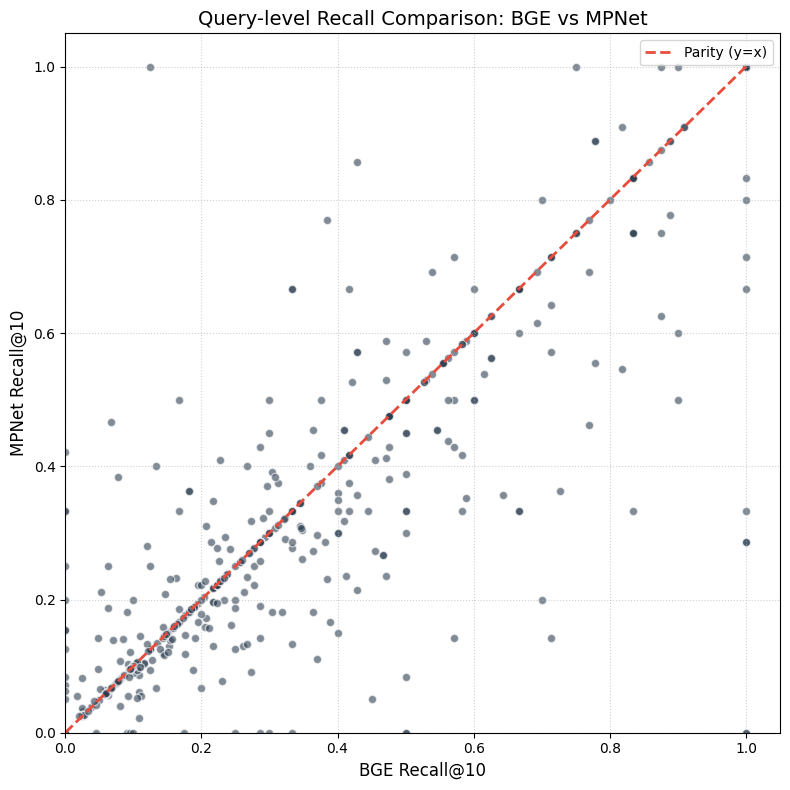

In [51]:
# Visualize model comparison with a scatter plot
# X-axis: BGE Recall@10, Y-axis: MPNet Recall@10
# Reference: Gemini
# 1. Merge the evaluation results on query_id
comparison_df = pd.merge(
    bge_eval[['query_id', 'query', 'recall']], 
    semantic_eval[['query_id', 'recall']], 
    on='query_id', 
    suffixes=('_bge', '_mpnet')
)

# 2. Create the Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(
    comparison_df['recall_bge'], 
    comparison_df['recall_mpnet'], 
    alpha=0.6, 
    color='#2c3e50',
    edgecolors='w'
)

# 3. Add the Diagonal Line (y=x)
# This shows where the two models perform exactly the same
plt.plot([0, 1], [0, 1], color='#e74c3c', linestyle='--', linewidth=2, label='Parity (y=x)')

# 4. Labeling
plt.xlabel('BGE Recall@10', fontsize=12)
plt.ylabel('MPNet Recall@10', fontsize=12)
plt.title('Query-level Recall Comparison: BGE vs MPNet', fontsize=14)
plt.xlim(0, 1.05) # Add a little padding
plt.ylim(0, 1.05)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.savefig('model_comparison_scatter.png')

---

## Task 6: Git Submission (5 points)

Submit your work using the Git workflow:

- [ ] Create a new branch called `homework-4`
- [ ] Commit your work with a meaningful message
- [ ] Push to GitHub
- [ ] Create a Pull Request
- [ ] Merge the PR to main
- [ ] Submit the `.ipynb` file on Blackboard

The TA will verify your submission by checking the merged PR on GitHub.